In [31]:
import pandas as pd

X_unfiltered = pd.read_csv('../X_train.csv')
y = pd.read_csv('../y_train.csv')
y = y.values.ravel()
X_test1 = pd.read_csv('../X_test_1.csv')
X_test2 = pd.read_csv('../X_test_2.csv')
y_test_2 = pd.read_csv('../y_test_2_reduced.csv')
y_test_2 = y_test_2.values.ravel()


In [3]:
# Check for missing values
missing = X_unfiltered.isnull().sum()
missing = missing[missing > 0]
print(missing)

#no missing values

Series([], dtype: int64)


In [4]:
# optional -> Used if needed for model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unfiltered)
X_test_scaled = scaler.transform(X_test1)



In [8]:
class_counts = pd.Series(y).value_counts().sort_index()
print("Class counts:\n", class_counts)


Class counts:
 0       18
1        7
2        7
3       65
4      238
5     4479
6      553
7      103
8      516
9       25
10    1081
11      78
12     457
13      62
14     264
15      26
16       6
17     354
18      60
19     177
20     153
21     269
22       7
23      41
24     385
25     184
26     278
27     107
Name: count, dtype: int64


In [9]:
class_percentages = pd.Series(y).value_counts(normalize=True).sort_index() * 100
print("Class percentages:\n", class_percentages)

Class percentages:
 0      0.18
1      0.07
2      0.07
3      0.65
4      2.38
5     44.79
6      5.53
7      1.03
8      5.16
9      0.25
10    10.81
11     0.78
12     4.57
13     0.62
14     2.64
15     0.26
16     0.06
17     3.54
18     0.60
19     1.77
20     1.53
21     2.69
22     0.07
23     0.41
24     3.85
25     1.84
26     2.78
27     1.07
Name: proportion, dtype: float64


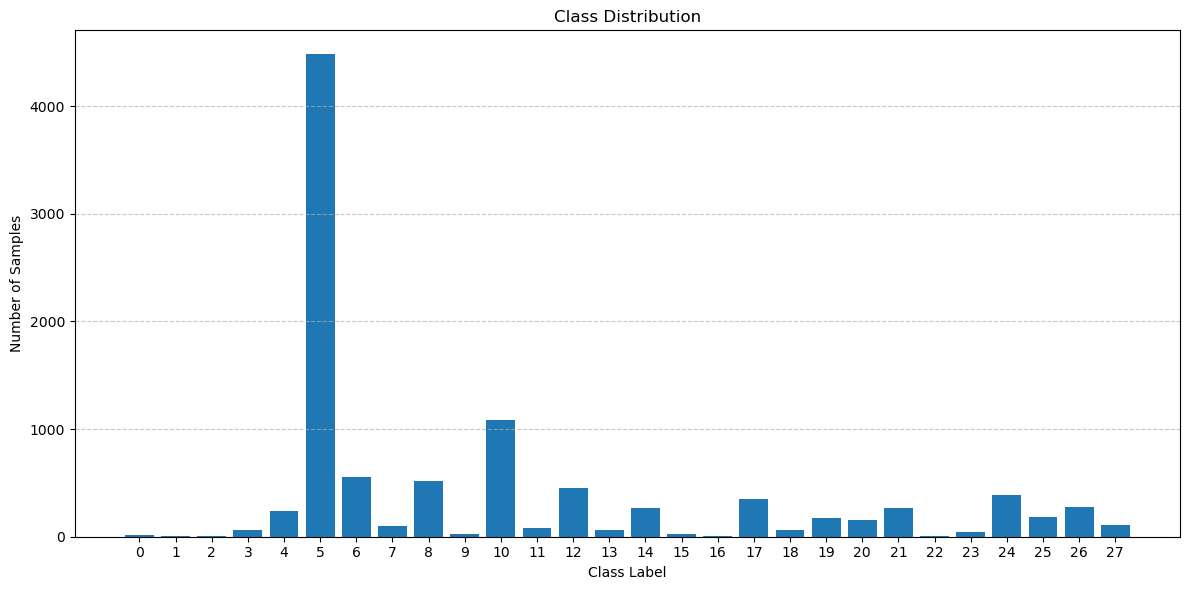

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(class_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


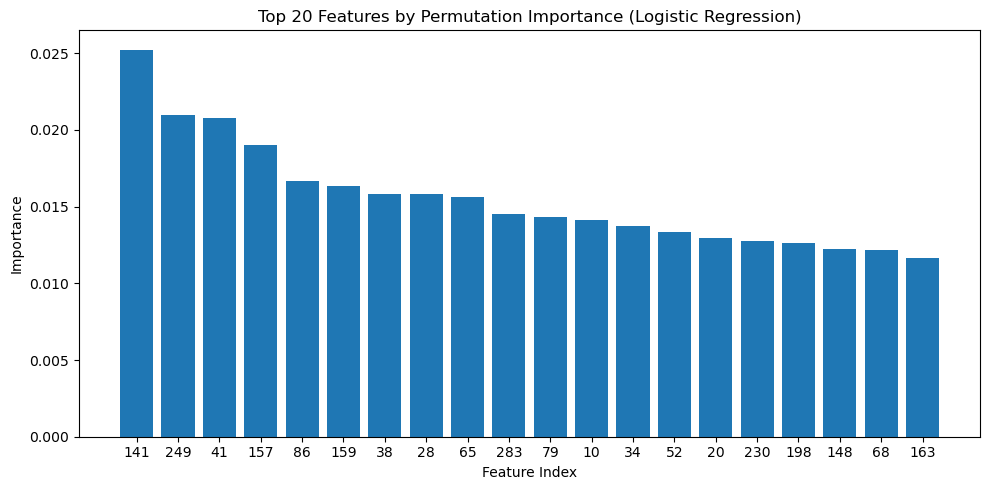

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=1000, penalty='l2')
logreg.fit(X_train_og, y_train_og)

result = permutation_importance(logreg, X_val_og, y_val_og, n_repeats=10, scoring='f1_weighted', random_state=42)

sorted_idx = result.importances_mean.argsort()[::-1][:20]
plt.figure(figsize=(10, 5))
plt.bar(range(20), result.importances_mean[sorted_idx])
plt.xticks(range(20), sorted_idx)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Top 20 Features by Permutation Importance (Logistic Regression)")
plt.tight_layout()
plt.show()


In [12]:
X_top20 = X_scaled[:, sorted_idx]
X_test_top20 = X_test_scaled[:, sorted_idx]

In [50]:
def weighted_log_loss(y_true, y_pred, eps=1e-15):
    """
    Compute the weighted cross-entropy (log loss) given true labels and predicted probabilities.
    
    Parameters:
    - y_true: (N, C) One-hot encoded true labels
    - y_pred: (N, C) Predicted probabilities
    
    Returns:
    - Weighted log loss (scalar).
    """

    y_pred = np.clip(y_pred, eps, 1 - eps)
    # Compute class frequencies
    class_counts = np.sum(y_true, axis=0)  # Sum over samples to get counts per class
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)  # Normalize weights to sum to 1
    
    # Compute weighted loss
    sample_weights = np.sum(y_true * class_weights, axis=1)  # Get weight for each sample
    loss = -np.mean(sample_weights * np.sum(y_true * np.log(y_pred), axis=1))
    
    return loss

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_top20, y, test_size=0.2, stratify=y, random_state=42)

clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_val)

y_val_oh_dt = np.zeros((y_val.shape[0], len(np.unique(y_train))))
y_val_oh_dt[np.arange(y_val.shape[0]), y_val] = 1


loss = weighted_log_loss(y_val_oh_dt, y_pred_prob)
print(f"Weighted Log Loss: {loss:.4f}")



Weighted Log Loss: 0.0784


In [14]:

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Apply MoM-style oversampling to training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Define base classifiers
log_clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
tree_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier(n_estimators=100)

# Create a soft voting ensemble
ensemble_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('tree', tree_clf), ('rf', rf_clf)],
    voting='soft'
)

# Train ensemble on resampled (balanced) data
ensemble_clf.fit(X_resampled, y_resampled)

# Evaluate on original validation set
y_pred_ensemble = ensemble_clf.predict(X_val)
print("Classification Report (Ensemble with MoM Resampling):")
print(classification_report(y_val, y_pred_ensemble, digits=3))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report (Ensemble with MoM Resampling):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000        13
           4      0.094     0.104     0.099        48
           5      0.791     0.805     0.798       896
           6      0.660     0.595     0.626       111
           7      0.158     0.143     0.150        21
           8      0.280     0.291     0.286       103
           9      0.000     0.000     0.000         5
          10      0.480     0.449     0.464       216
          11      0.294     0.312     0.303        16
          12      0.189     0.154     0.170        91
          13      0.000     0.000     0.000        12
          14      0.067     0.075     0.071        53
          15      0.333     0.200     0.250         5
          16      0.000    

## XGboost

In [15]:
def weighted_log_loss(y_true, y_pred):
    """
    Compute the weighted cross-entropy (log loss) given true labels and predicted probabilities.
    
    Parameters:
    - y_true: (N, C) One-hot encoded true labels
    - y_pred: (N, C) Predicted probabilities
    
    Returns:
    - Weighted log loss (scalar).
    """
    # Compute class frequencies
    class_counts = np.sum(y_true, axis=0)  # Sum over samples to get counts per class
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)  # Normalize weights to sum to 1
    
    # Compute weighted loss
    sample_weights = np.sum(y_true * class_weights, axis=1)  # Get weight for each sample
    loss = -np.mean(sample_weights * np.sum(y_true * np.log(y_pred), axis=1))
    
    return loss

In [58]:
# Install required libraries if needed

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# 3. XGBoost with sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

xgb = XGBClassifier(objective='multi:softmax',
                    num_class=len(np.unique(y_train_og)),
                    eval_metric='mlogloss',
                    max_depth=3,
                    reg_alpha=2,
                    random_state=42)

xgb.fit(X_train_og, y_train_og, sample_weight=sample_weights)
y_pred_xgb = xgb.predict(X_val_og)
print("=== XGBoost with Sample Weights ===")
y_pred_proba_xgb = xgb.predict_proba(X_val_og)
print(classification_report(y_val_og, y_pred_xgb, digits=3))


y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1


loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb)
print(f"Weighted Log Loss: {loss:.4f}")

=== XGBoost with Sample Weights ===
              precision    recall  f1-score   support

           0      1.000     0.250     0.400         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.364     0.308     0.333        13
           4      0.500     0.583     0.538        48
           5      0.925     0.856     0.889       896
           6      0.835     0.910     0.871       111
           7      0.471     0.381     0.421        21
           8      0.650     0.738     0.691       103
           9      0.000     0.000     0.000         5
          10      0.752     0.801     0.776       216
          11      0.455     0.625     0.526        16
          12      0.476     0.538     0.505        91
          13      0.000     0.000     0.000        12
          14      0.090     0.132     0.107        53
          15      0.400     0.400     0.400         5
          16      0.500     1.000     0.667  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
# Install required libraries if needed
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # <--- to combine them easily

# 1. Create SMOTE + RandomUnderSampler pipeline
over = SMOTE(random_state=42, k_neighbors=1)
under = RandomUnderSampler(random_state=42)

# Combine them
resample_pipeline = Pipeline([
    ('o', over),
    ('u', under)
])

# 2. Apply SMOTE + RandomUnderSampler
X_train_balanced, y_train_balanced = resample_pipeline.fit_resample(X_train_og, y_train_og)

# 3. Compute sample weights after resampling
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_balanced)

# 4. Train XGB_1oost
xgb_1 = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_balanced)),  # important: based on new labels
    eval_metric='mlogloss',
    max_depth=3,
    reg_alpha=2,
    random_state=42
)

xgb_1.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# 5. Predict
y_pred_xgb_1 = xgb_1.predict(X_val_og)
y_pred_proba_xgb_1 = xgb_1.predict_proba(X_val_og)

# 6. Evaluation
print("=== XGB_1oost with SMOTE + Random Undersampling ===")
print(classification_report(y_val_og, y_pred_xgb_1, digits=3))

# 7. Weighted Log Loss calculation
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_balanced))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_1)
print(f"Weighted Log Loss: {loss:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:27:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGB_1oost with SMOTE + Random Undersampling ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.308     0.308     0.308        13
           4      0.545     0.625     0.583        48
           5      0.899     0.898     0.899       896
           6      0.887     0.919     0.903       111
           7      0.600     0.429     0.500        21
           8      0.691     0.738     0.714       103
           9      0.000     0.000     0.000         5
          10      0.803     0.829     0.815       216
          11      0.625     0.625     0.625        16
          12      0.500     0.549     0.524        91
          13      0.167     0.083     0.111        12
          14      0.049     0.057     0.053        53
          15      0.600     0.600     0.600         5
          16      1.000     1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
def weighted_log_loss_scorer(estimator, X, y):
    # estimator is the model (XGBClassifier)
    # X is the validation data
    # y is the true labels

    y_pred_proba = estimator.predict_proba(X)

    # One-hot encode y_true manually
    y_val_oh = np.zeros((y.shape[0], y_pred_proba.shape[1]))
    y_val_oh[np.arange(y.shape[0]), y] = 1

    loss = weighted_log_loss(y_val_oh, y_pred_proba)

    return -loss  # flip sign because lower loss = better

In [57]:
# Install required libraries if needed
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import make_scorer

scorer = make_scorer(weighted_log_loss, greater_is_better=False)

# 1. Compute sample weights (before tuning)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

# 2. Define parameter grid for tuning
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800]
}

# 3. Set up XGBClassifier base model
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train_og)),
    eval_metric='mlogloss',
    random_state=42
)

# 4. Randomized Search for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,  # Try 30 random combinations
    scoring=weighted_log_loss_scorer, 
    cv=3,
    random_state=42,
    n_jobs=-1,
)

# 5. Fit RandomizedSearchCV
random_search.fit(X_train_og, y_train_og, sample_weight=sample_weights)

# 6. Retrieve the best model
best_xgb = random_search.best_estimator_

print("\nBest Hyperparameters:", random_search.best_params_)

# 7. Predict and Evaluate
y_pred_xgb_hpt = best_xgb.predict(X_val_og)
y_pred_proba_xgb_hpt = best_xgb.predict_proba(X_val_og)

print("\n=== XGBoost with Tuned Hyperparameters ===")
print(classification_report(y_val_og, y_pred_xgb_hpt, digits=3))

# 8. Calculate Weighted Log Loss
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_hpt)
print(f"Weighted Log Loss: {loss:.4f}")



Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}

=== XGBoost with Tuned Hyperparameters ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.400     0.308     0.348        13
           4      0.537     0.604     0.569        48
           5      0.938     0.834     0.883       896
           6      0.841     0.955     0.895       111
           7      0.600     0.429     0.500        21
           8      0.652     0.728     0.688       103
           9      0.000     0.000     0.000         5
          10      0.786     0.801     0.794       216
          11      0.458     0.688     0.550        16
          12      0.534     0.604     0.567        91
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


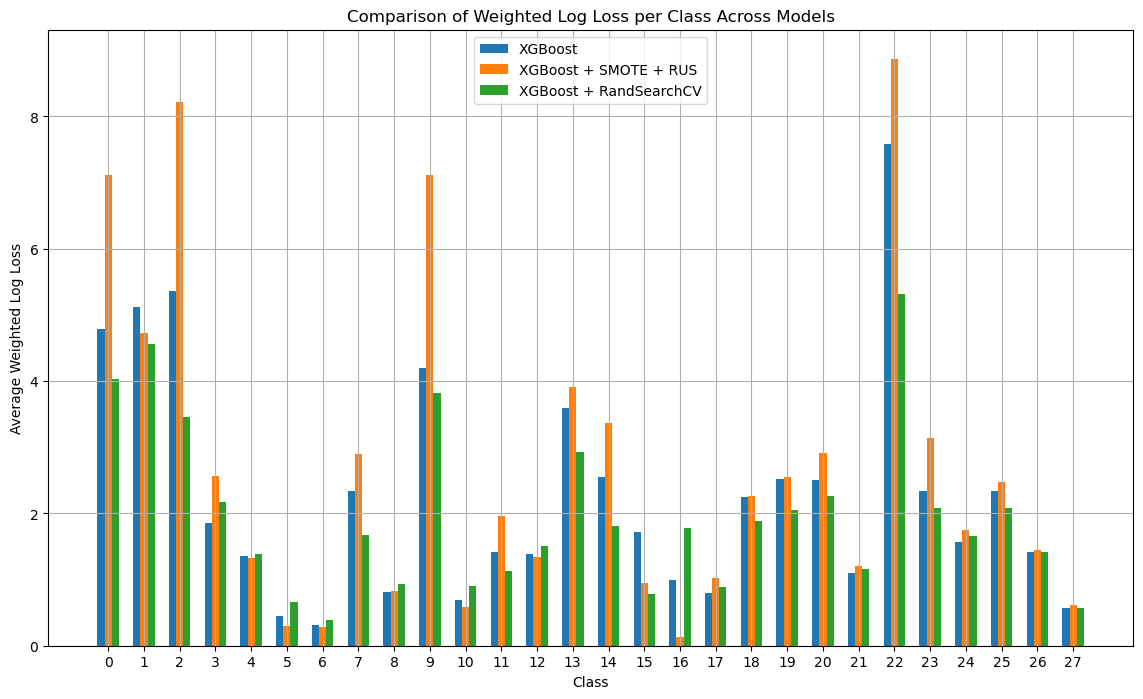

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def compute_class_loss(y_true_oh, y_pred_prob):
    eps = 1e-15
    y_pred_prob_clipped = np.clip(y_pred_prob, eps, 1 - eps)
    sample_losses = -np.sum(y_true_oh * np.log(y_pred_prob_clipped), axis=1)
    true_classes = np.argmax(y_true_oh, axis=1)
    
    losses_by_class = {}
    for c in np.unique(true_classes):
        losses_by_class[c] = sample_losses[true_classes == c]
    
    avg_loss_per_class = {c: np.mean(losses) for c, losses in losses_by_class.items()}
    return avg_loss_per_class

# Assume you have multiple models' predicted probabilities ready:
# For example:
# y_pred_prob_dt = decision tree probabilities
# y_pred_prob_xgb = xgboost probabilities
# y_pred_prob_rf = random forest probabilities

models = {
    'XGBoost': y_pred_proba_xgb,
    'XGBoost + SMOTE + RUS':y_pred_proba_xgb_1,
    'XGBoost + RandSearchCV':y_pred_proba_xgb_hpt,
    # Add other models here if needed, e.g.
    # 'Random Forest': y_pred_prob_rf
}

# Calculate per-class average loss for each model
loss_per_class_all_models = {}

for model_name, probs in models.items():
    loss_per_class = compute_class_loss(y_val_oh, probs)
    loss_per_class_all_models[model_name] = loss_per_class

# Now prepare to plot
classes = sorted(list(loss_per_class_all_models['XGBoost'].keys()))
x = np.arange(len(classes))  # Class indices for x-axis
width = 0.2  # Width of each bar

plt.figure(figsize=(14,8))

for idx, (model_name, class_losses) in enumerate(loss_per_class_all_models.items()):
    losses = [class_losses[c] for c in classes]
    plt.bar(x + idx * width, losses, width=width, label=model_name)

plt.xlabel('Class')
plt.ylabel('Average Weighted Log Loss')
plt.title('Comparison of Weighted Log Loss per Class Across Models')
plt.xticks(x + width * (len(models) - 1) / 2, classes)
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Install required libraries if needed
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import make_scorer

scorer = make_scorer(weighted_log_loss, greater_is_better=False)

# 1. Compute sample weights (before tuning)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_og)

# 2. Define parameter grid for tuning
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800]
}

# 3. Set up XGBClassifier base model
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train_og)),
    eval_metric='mlogloss',
    random_state=42
)

# 4. Randomized Search for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=50,  # Try 30 random combinations
    scoring=weighted_log_loss_scorer, 
    cv=5,
    random_state=42,
    n_jobs=-1,
)

# 5. Fit RandomizedSearchCV
random_search.fit(X_train_og, y_train_og, sample_weight=sample_weights)

# 6. Retrieve the best model
best_xgb = random_search.best_estimator_

print("\nBest Hyperparameters:", random_search.best_params_)

# 7. Predict and Evaluate
y_pred_xgb = best_xgb.predict(X_val_og)
y_pred_proba_xgb = best_xgb.predict_proba(X_val_og)

print("\n=== XGBoost with Tuned Hyperparameters ===")
print(classification_report(y_val_og, y_pred_xgb, digits=3))

# 8. Calculate Weighted Log Loss
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb)
print(f"Weighted Log Loss: {loss:.4f}")



Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 2, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}

=== XGBoost with Tuned Hyperparameters ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.400     0.308     0.348        13
           4      0.537     0.604     0.569        48
           5      0.938     0.834     0.883       896
           6      0.841     0.955     0.895       111
           7      0.600     0.429     0.500        21
           8      0.652     0.728     0.688       103
           9      0.000     0.000     0.000         5
          10      0.786     0.801     0.794       216
          11      0.458     0.688     0.550        16
          12      0.534     0.604     0.567        91
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Improved class weights manually
classes = np.unique(y_train_og)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_og)

# Now create sample weights: map the class weight for each sample
class_weight_dict = dict(zip(classes, class_weights_array))
sample_weights = np.array([class_weight_dict[label] for label in y_train_og])

# 2. Use XGBClassifier with softprob (recommended for probability training)
xgb_1 = XGBClassifier(
    objective='multi:softprob',   # <--- changed from softmax to softprob
    num_class=len(classes),
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=3,
    reg_alpha=2,
    random_state=42,
    learning_rate=0.05,   # <--- added: slower learning
    n_estimators=500,     # <--- added: more trees to compensate
    min_child_weight=10,
)

# 3. Fit the model
xgb_1.fit(X_train_og, y_train_og, sample_weight=sample_weights)

# 4. Predict probabilities
y_pred_proba_xgb_1 = xgb_1.predict_proba(X_val_og)

# 5. Predict labels (manual argmax since using softprob)
y_pred_xgb = np.argmax(y_pred_proba_xgb_1, axis=1)

# 6. Evaluation
print("=== XGBoost with Improved Sample Weights ===")
print(classification_report(y_val_og, y_pred_xgb, digits=3))

# 7. Calculate your custom weighted log loss
y_val_oh = np.zeros((y_val_og.shape[0], len(np.unique(y_train_og))))
y_val_oh[np.arange(y_val_og.shape[0]), y_val_og] = 1

loss = weighted_log_loss(y_val_oh, y_pred_proba_xgb_1)
print(f"Weighted Log Loss: {loss:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost with Improved Sample Weights ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.000     0.000     0.000         1
           2      0.000     0.000     0.000         1
           3      0.385     0.385     0.385        13
           4      0.458     0.562     0.505        48
           5      0.930     0.850     0.889       896
           6      0.833     0.901     0.866       111
           7      0.562     0.429     0.486        21
           8      0.658     0.728     0.691       103
           9      0.000     0.000     0.000         5
          10      0.781     0.810     0.795       216
          11      0.476     0.625     0.541        16
          12      0.537     0.560     0.548        91
          13      0.200     0.083     0.118        12
          14      0.109     0.189     0.138        53
          15      0.714     1.000     0.833         5
          16      1.000     1.000   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


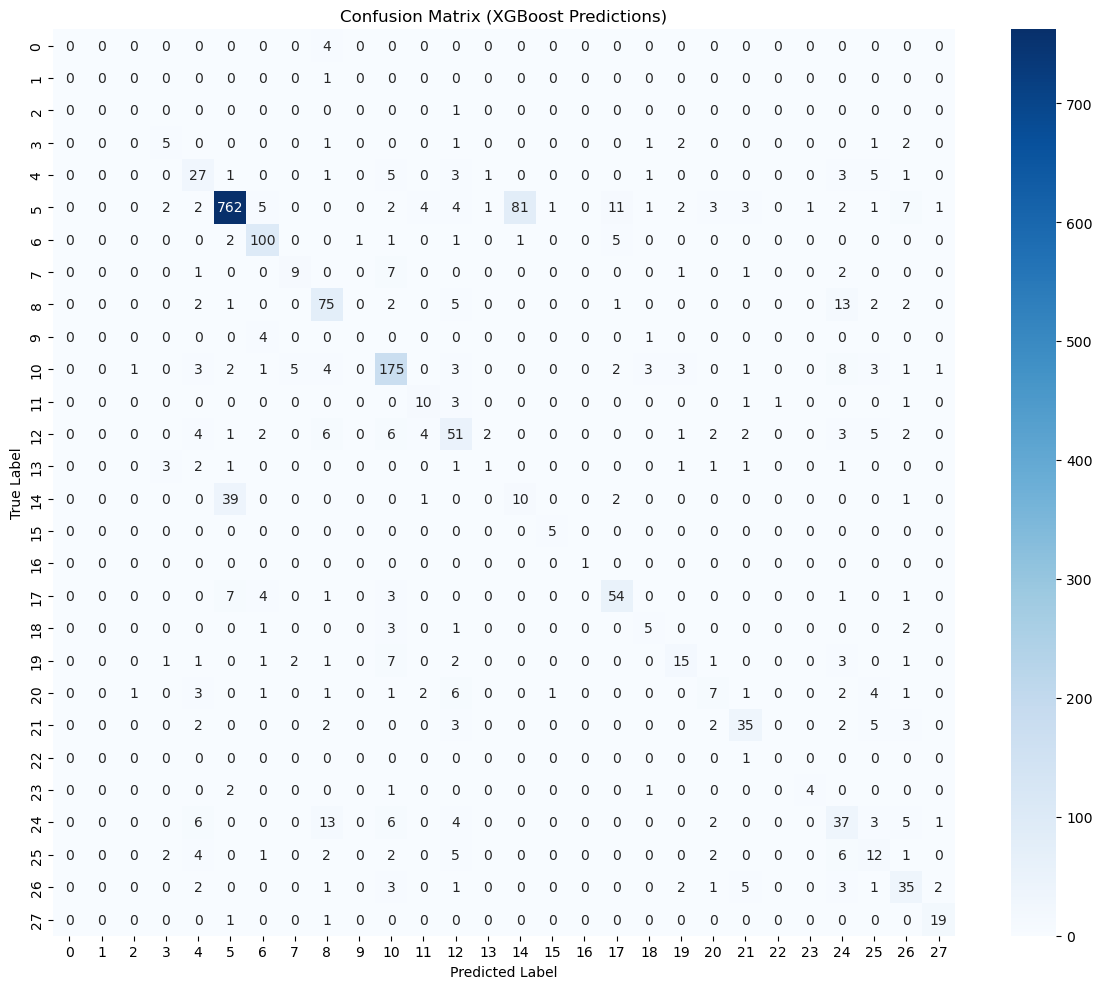

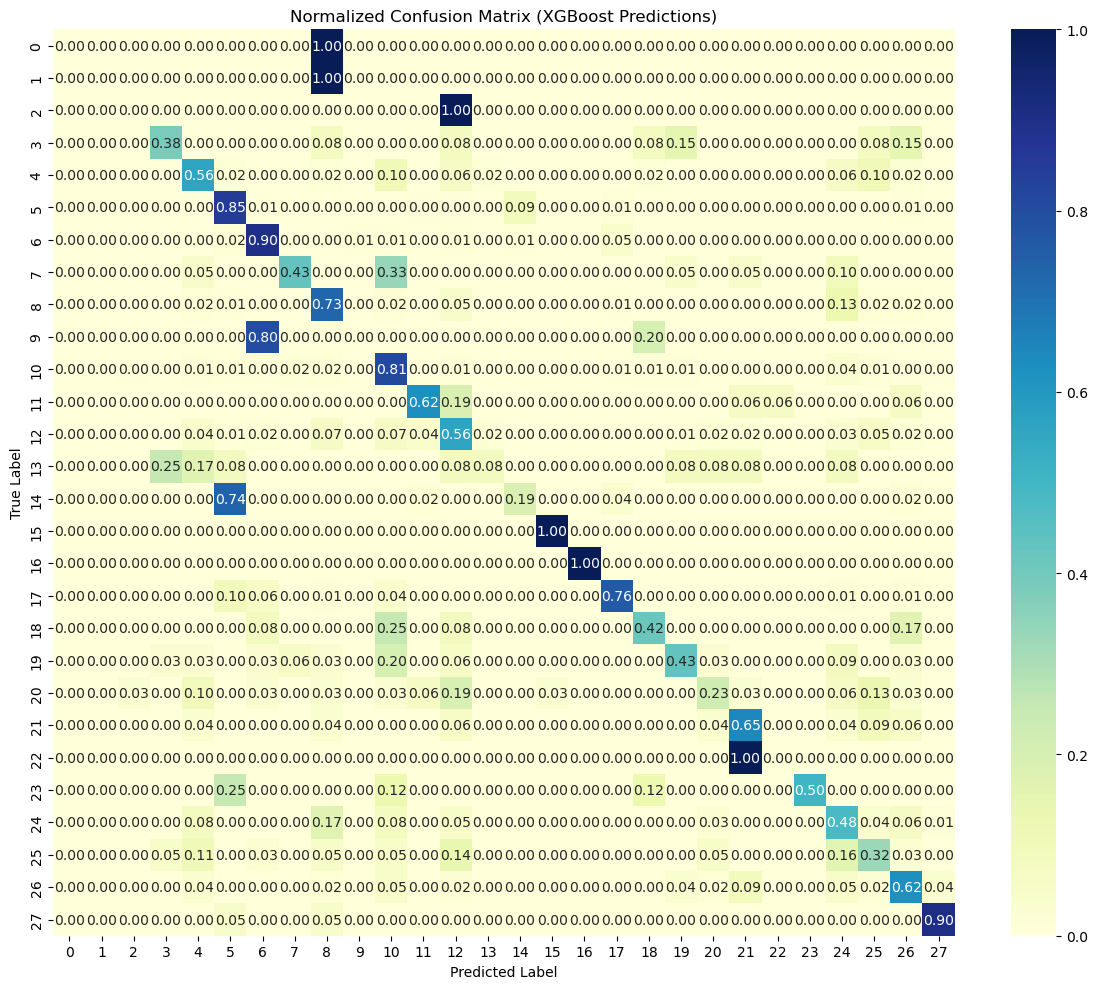

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


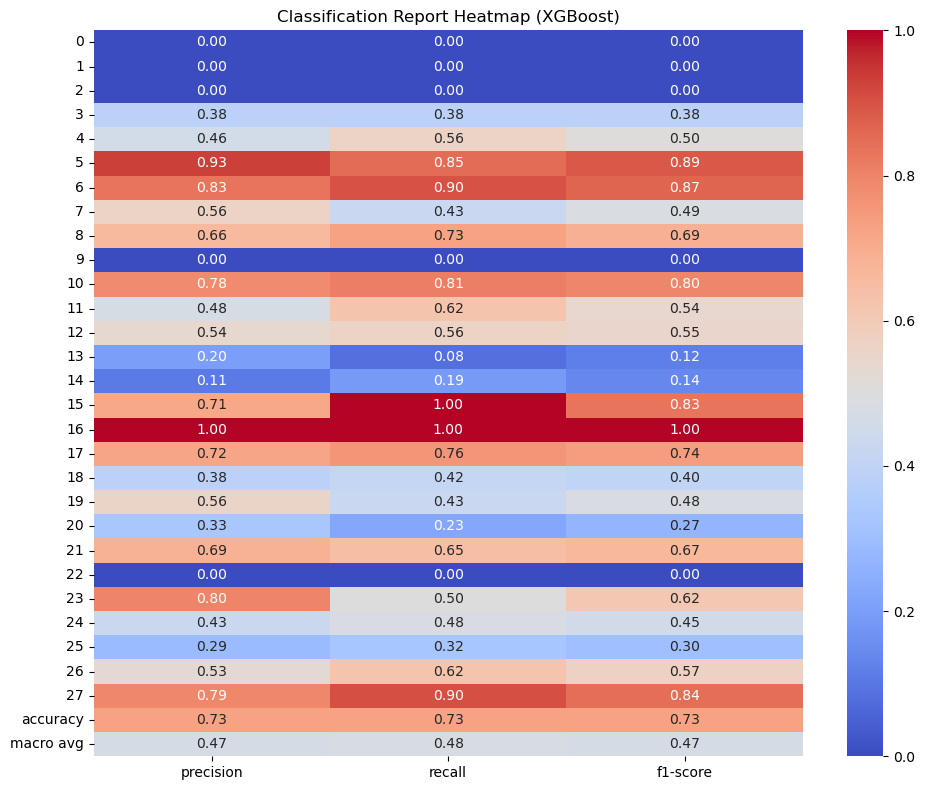

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

conf_mat = confusion_matrix(y_val_og, y_pred_xgb)
conf_mat_normalized = confusion_matrix(y_val_og, y_pred_xgb, normalize='true')

# 1. Confusion Matrix (raw counts)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (XGBoost Predictions)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 2. Normalized Confusion Matrix (per row/class)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Normalized Confusion Matrix (XGBoost Predictions)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# --- Classification Report Heatmap ---
report = classification_report(y_val_og, y_pred_xgb, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 3. Classification Report as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Classification Report Heatmap (XGBoost)")
plt.tight_layout()
plt.show()

In [20]:
y_pred_xgb_real = xgb.predict(X_test1)
print("=== XGBoost with Sample Weights on Text ===")
print(y_pred_xgb_real)

=== XGBoost with Sample Weights on Text ===
[ 5  5 10 17 12  7  5  5  6 26 10 27  5  5  5  0  8 10  5 17 24  5 24  5
  5  5 12 10  5  5 26  5  5 17  5 14  5  8 10  5 20 17 10 10 24 10  5  5
 12 10 10  5 20  5  5  8  6  5  8  5 17  5 14  5  6  5  6 17  8 10 12  5
 13 25  5 17 14  5  5 17  5  5  5 20  5 17  5 24  5 17  5  5  5 10  5 12
  5 12  3 10 14  5 25  5  8  5 19  5 10 10  5 21  5 24 17 12 12  5  8  5
  5 25  5  5 24  5  5 10 10 21  4  5  4 24 24 27 20  6 12  5 17  5 11  3
  5  4 19  5 10 20  7  5  6 12 12 26 21  5 10 23  5 12  5  5  5  5  5  5
  8 12 10  5 12  7  8 15  5  5 24  8  5  6 17  5  4 19  8 24  5 12  5  7
 12  5  5  8 25 12  5 24  4  5 27 10  5  5  5  5  8  5 10  3  5  5 12  5
 10  8 12  5  5 27  5  6 17 12  5  8  5 24 21  6 10  8  5 12  5 10  5 25
  5  4 25 10 12 24 10  8 21 26 10  7 12 10 12 12 10  5  5 26  6 10  5  5
 27  8  5  8 11 26  5  8 10  6  5  6  8 10 10  5 25  7  5 26  5  8  5 26
  5 24  5  5  5  5 21  5 10 12  5  5  5 25 27  6  5  5 24 26 10 12 18 24
  5 17 